# Other

**Goal:** Bla

This notebook is divided in 2 parts:

* **1. Bla**

***

## The `mut_key` feature: study of reccurent mutations

Each mutations is identified by a unique key `mut_key` : `Chromosome`_`Start_Position`_`Reference_Allele`_`Tumor_Seq_Allele2`. The mutations sharing the same key are the same.

In [19]:
head(impact$mut_key)
length(unique(impact$mut_key)) # number of different keys e.g. number of different mutations

[1] "17_7577515_T_G"  "1_46521514_G_C"  "3_142178126_C_A" "4_55139732_T_A" 
[5] "4_153249542_C_A" "4_153332775_C_A"

[1] 135012

### Identify the reccurent mutations

We need to study the reccurence of mutations taking care not to consider a mutation as recurrent if it comes frome the same patient. To do so we will group the rows by patient, and select only the distinct mutations for each patient:

In [20]:
# create a patient id (no problem will be caused by 'None-T01-IM6' which will become 'None-T01-')
impact$patient_id <- substr(impact$Tumor_Sample_Barcode, 1, 9)
head(unique(impact$patient_id))

[1] "P-0000012" "P-0000023" "P-0000024" "P-0000025" "P-0000026" "P-0000030"

In [21]:
impact_unique_mut_keys_per_patient <- as.data.frame(impact %>% group_by(patient_id) %>%
                                                               select(patient_id, mut_key, Hugo_Symbol, Consequence, Variant_Type, class) %>%
                                                               filter(! duplicated(mut_key)))
nrow(impact)
nrow(impact_unique_mut_keys_per_patient)

[1] 198259

[1] 190526

In [22]:
mut_key_info <- as.data.frame(impact_unique_mut_keys_per_patient %>% group_by(mut_key) %>%
                                                                     summarise(count = n(), Hugo_Symbol = unique(Hugo_Symbol)))
head(mut_key_info)

mut_key,count,Hugo_Symbol
1_108206648_AGAAGTTG_GAAGTTGT,1,ARID1A
1_11167549_A_G,1,MTOR
1_11168271_G_A,1,MTOR
1_11168272_A_G,1,MTOR
1_11168304_G_A,1,MTOR
1_11168316_A_G,1,MTOR


In [23]:
for (threshold in c(2, 3, 5, 10)) {
    
    mut_key_info_threshold <- mut_key_info[mut_key_info$count >= threshold,]
    
    print(sprintf("%2.0f%% (%5d) of the keys are shared by at least %2d samples [%2.0f%% (%5d) of the rows concerned]",
                  100 * nrow(mut_key_info_threshold) / nrow(mut_key_info),
                  nrow(mut_key_info_threshold),
                  threshold,
                  100 * nrow(impact_unique_mut_keys_per_patient[impact_unique_mut_keys_per_patient$mut_key %in% mut_key_info_threshold$mut_key,]) / nrow(impact_unique_mut_keys_per_patient),
                  nrow(impact_unique_mut_keys_per_patient[impact_unique_mut_keys_per_patient$mut_key %in% mut_key_info_threshold$mut_key,])))
}

[1] "13% (17584) of the keys are shared by at least  2 samples [38% (73098) of the rows concerned]"
[1] " 5% ( 6245) of the keys are shared by at least  3 samples [26% (50420) of the rows concerned]"
[1] " 2% ( 2227) of the keys are shared by at least  5 samples [20% (37230) of the rows concerned]"
[1] " 1% (  855) of the keys are shared by at least 10 samples [15% (28717) of the rows concerned]"


Distribution of the mutations key count for the mutations present in at least 2 samples:

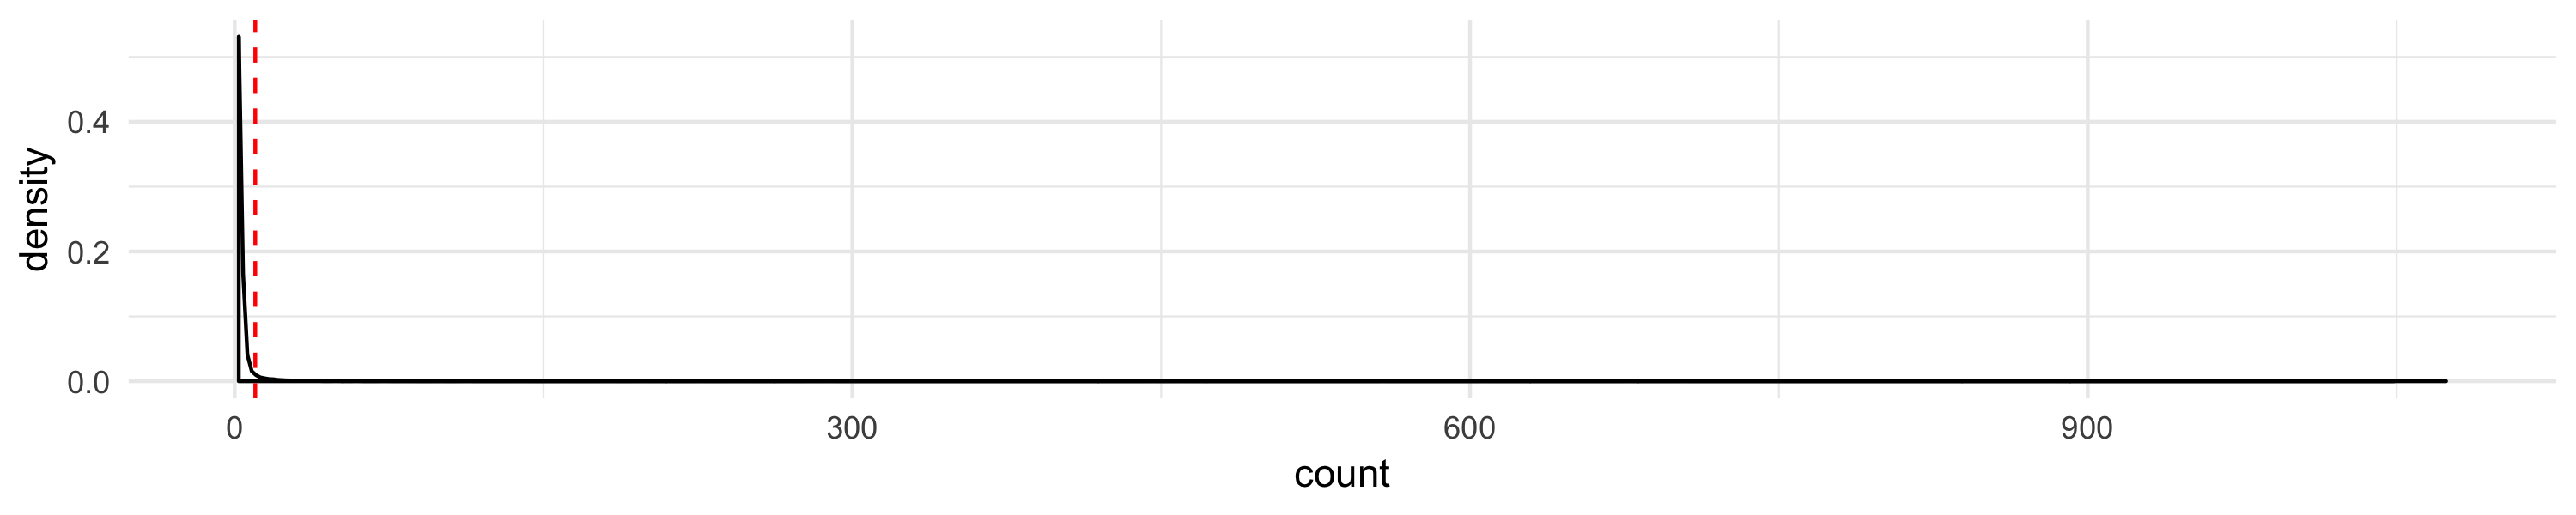

In [24]:
repeated_key <- mut_key_info[mut_key_info$count >= 2,] # keys shared by at least 2 samples
plot_density(repeated_key, "count", adjust = 5, lines = 10, height = 2)

### Sudy the reccurent mutations genes

In [25]:
length(unique(repeated_key$Hugo_Symbol))

[1] 463

In [26]:
head(repeated_key)

,mut_key,count,Hugo_Symbol
17,1_11169376_A_T,3,MTOR
18,1_11169377_T_A,3,MTOR
22,1_11169741_G_A,2,MTOR
28,1_11174379_C_T,2,MTOR
30,1_11174386_C_A,3,MTOR
31,1_11174395_A_C,4,MTOR


Here is a plot of the genes that are the most mutated **accross the mutation keys**:

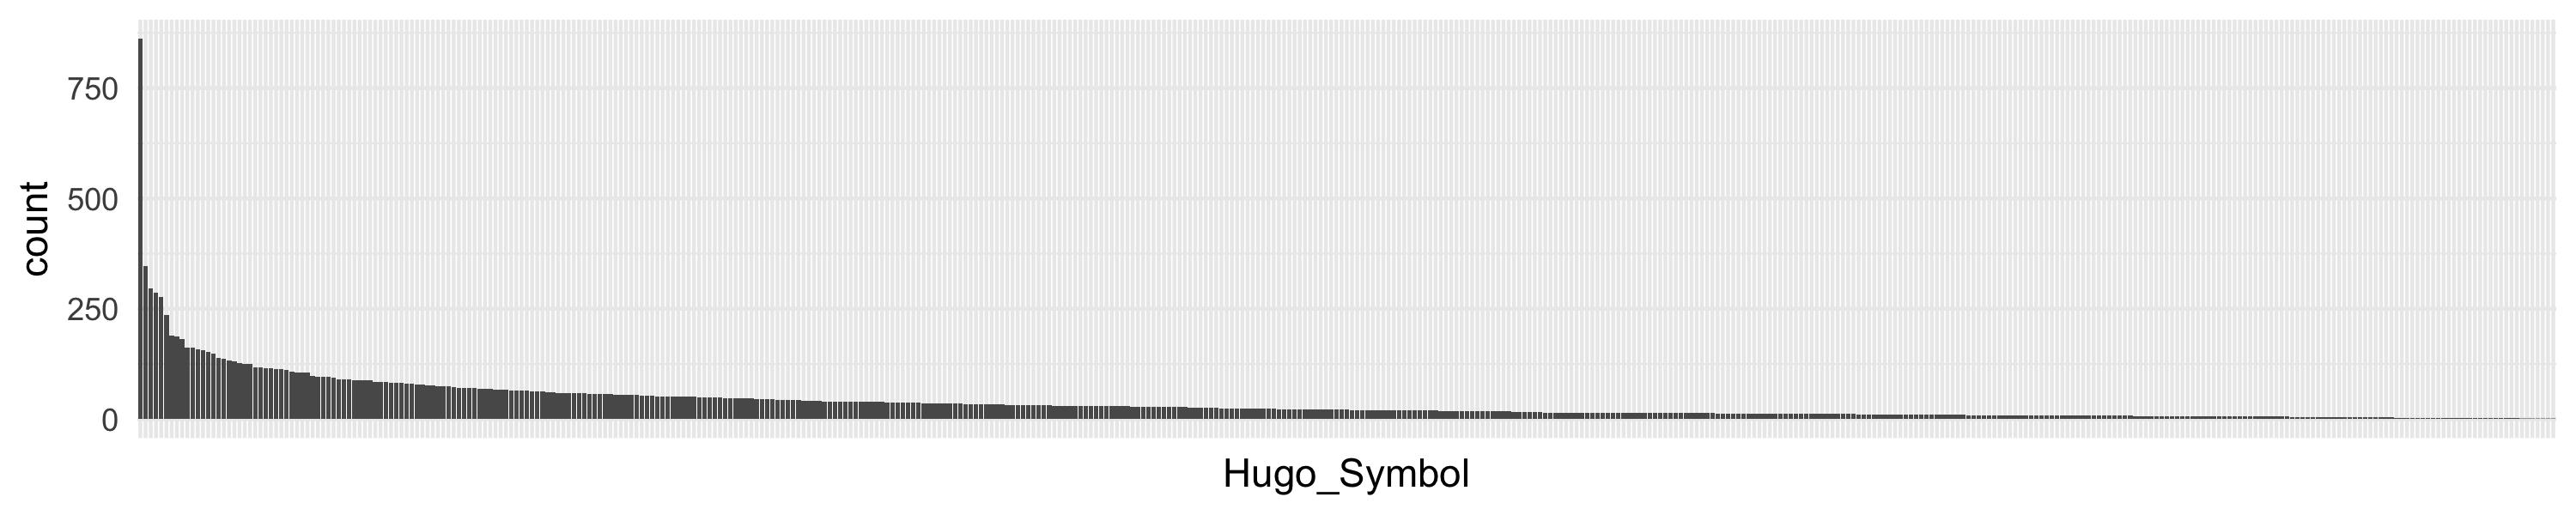

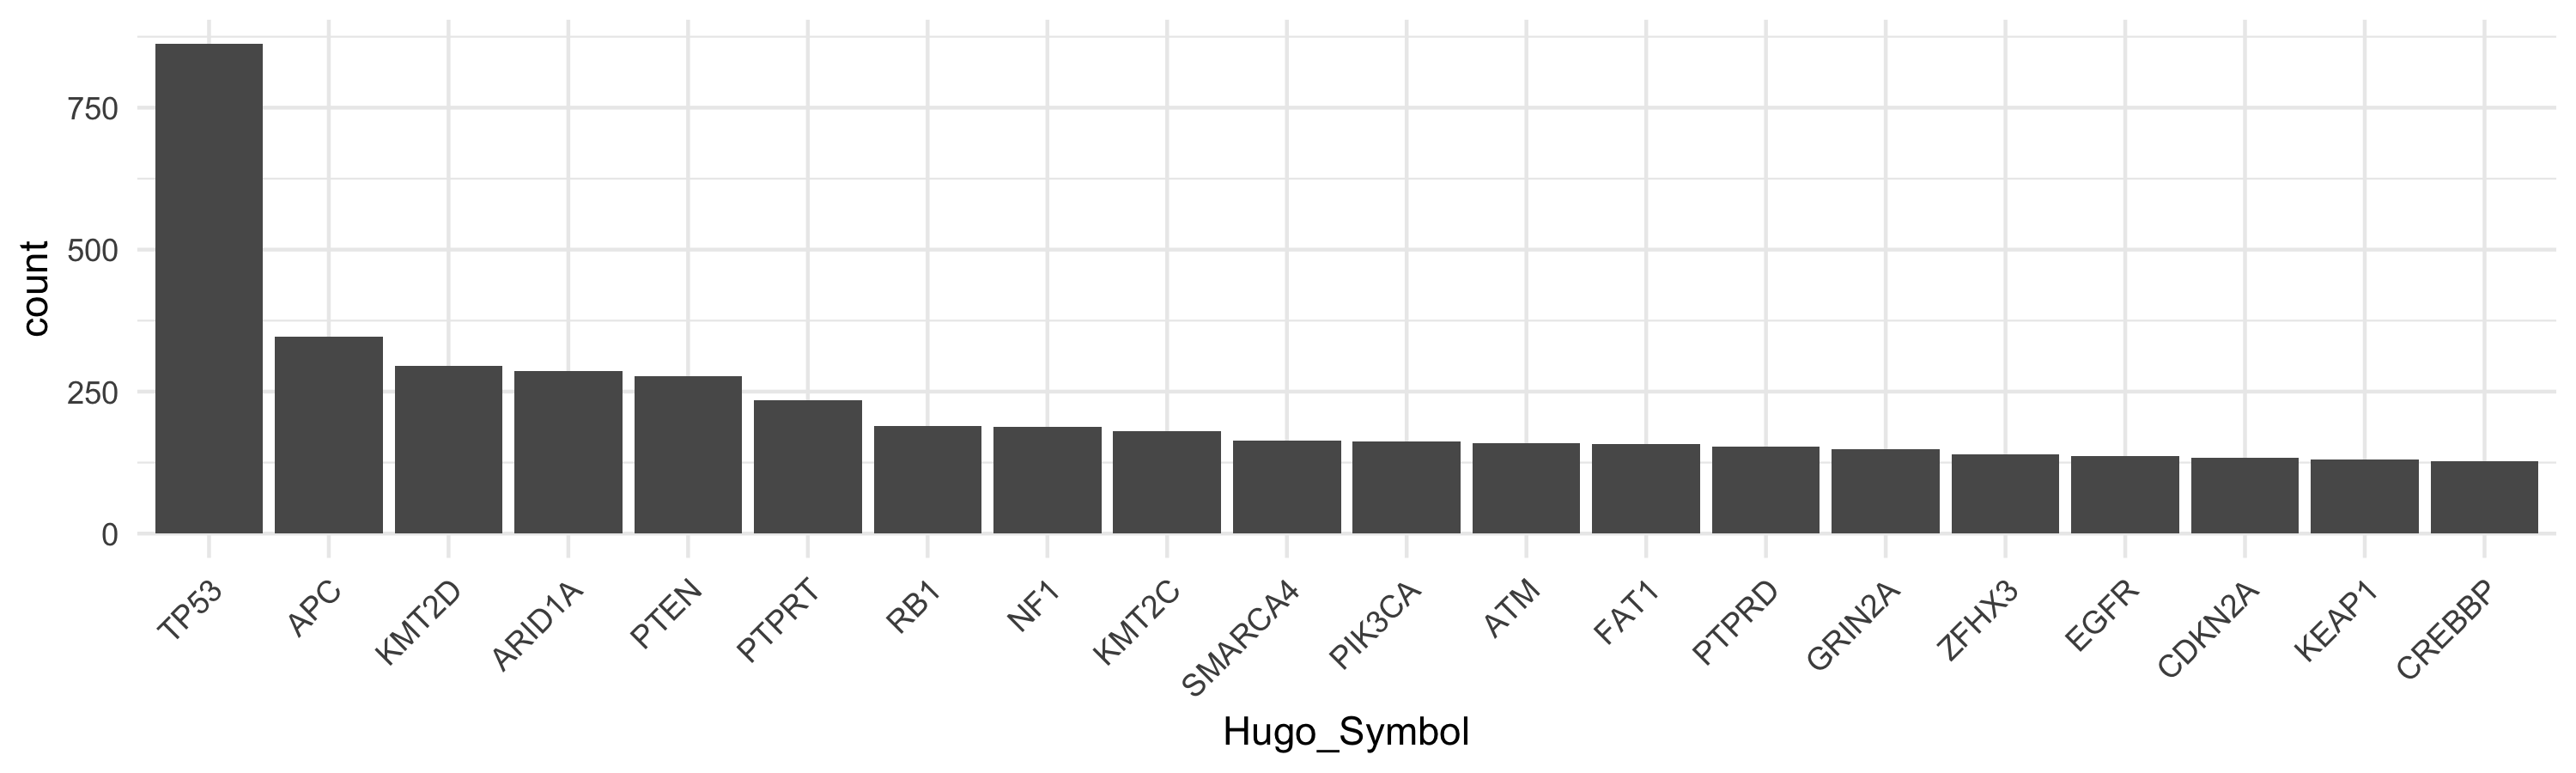

In [27]:
repeated_key <- sort_histogram(repeated_key, "Hugo_Symbol")
notebook_plot_size(10, 2)
ggplot(repeated_key) + geom_bar(aes(Hugo_Symbol)) + theme(axis.text.x = element_blank())
plot_histogram_top(repeated_key, "Hugo_Symbol", 20) + tilt_x_label_45()

Here is a plot of the genes that are the most mutated **accross the rows**:

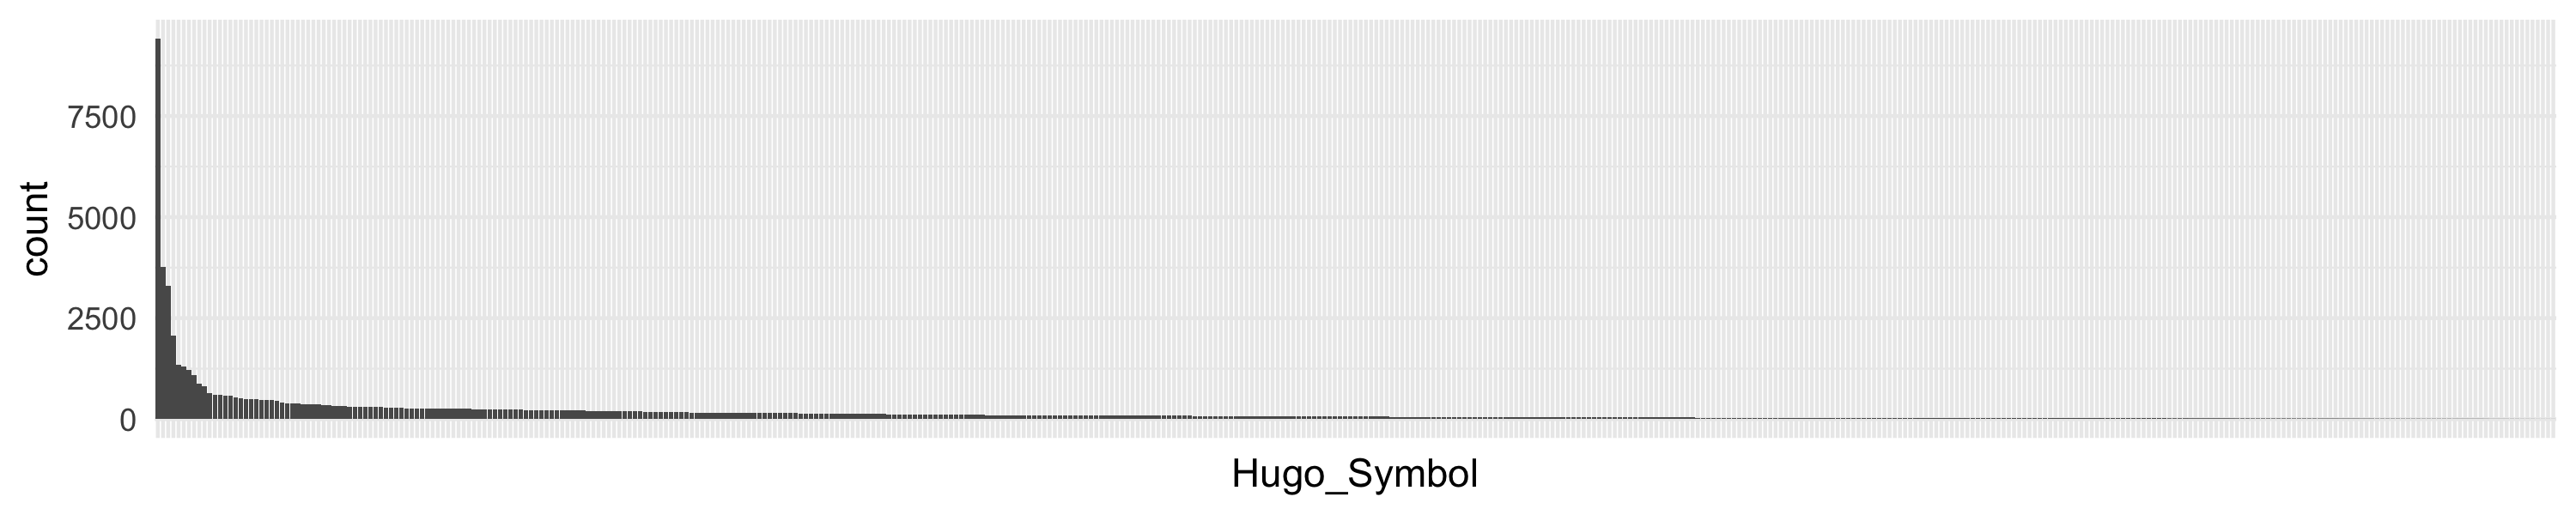

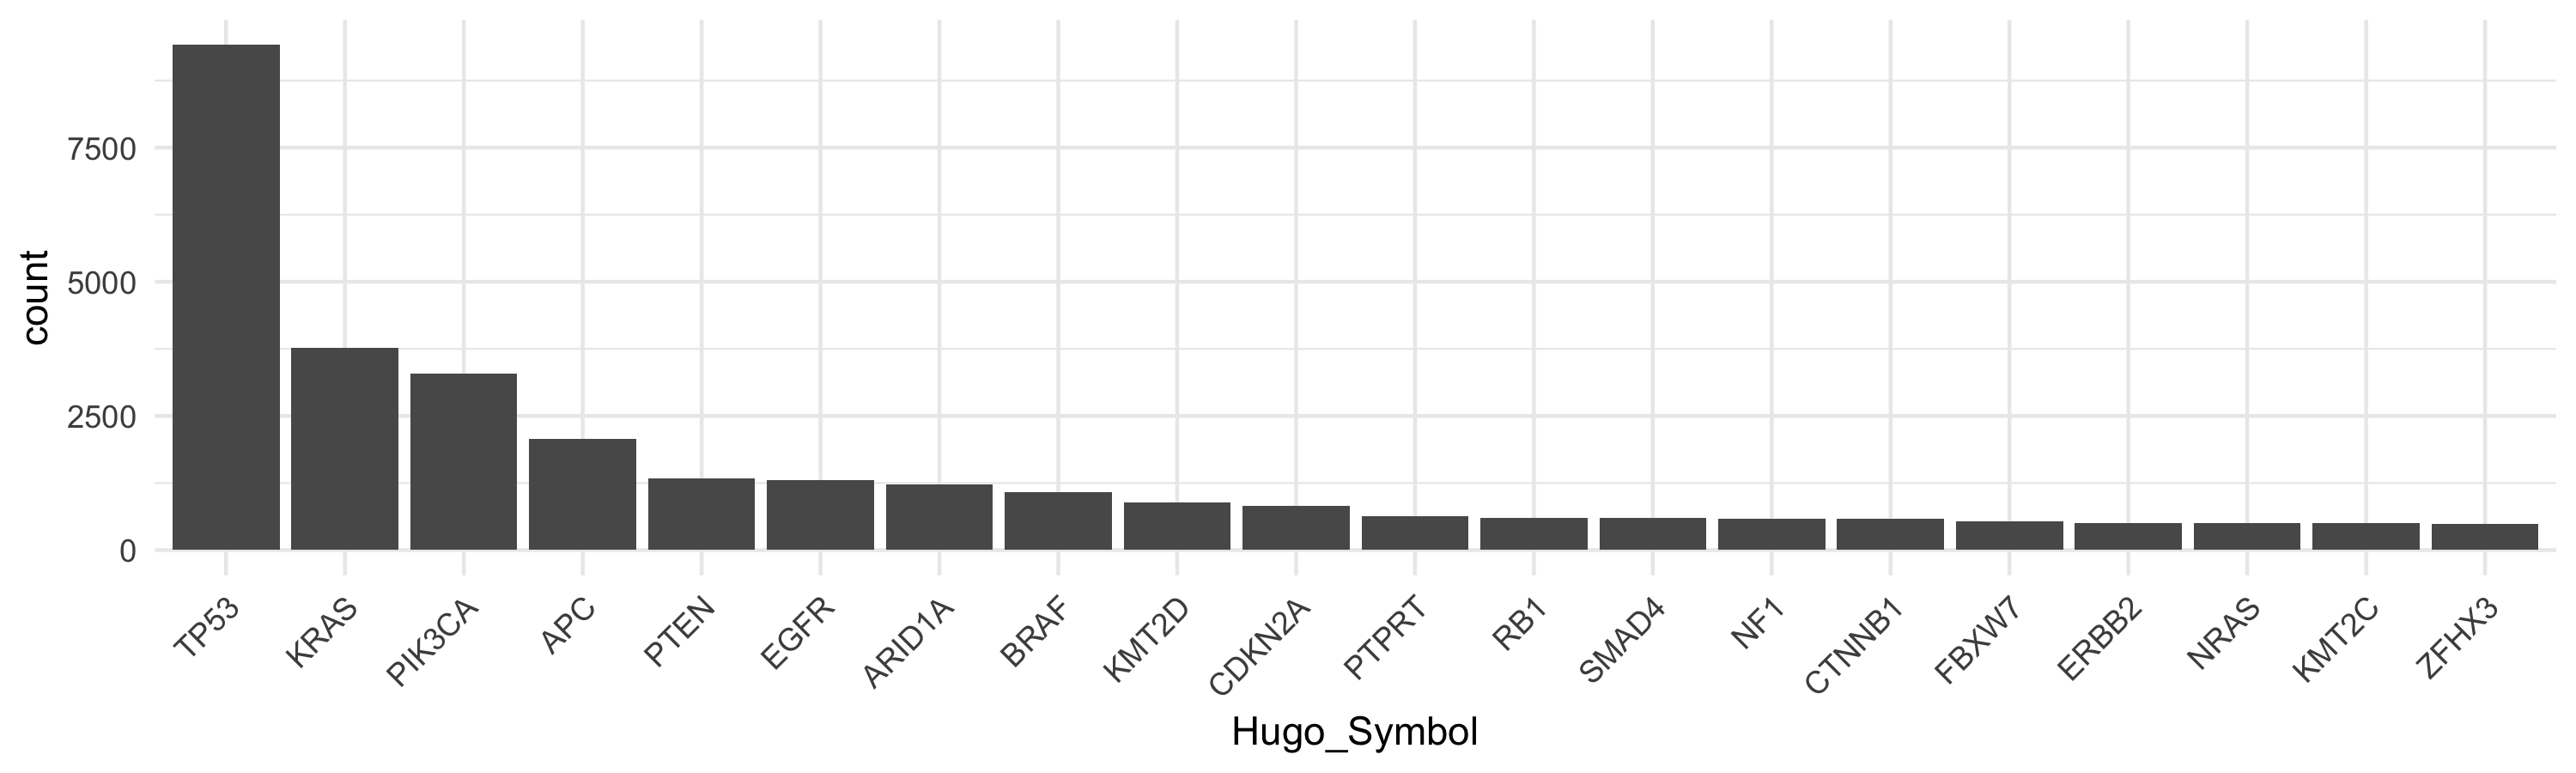

In [28]:
rec_impact <- impact_unique_mut_keys_per_patient[impact_unique_mut_keys_per_patient$mut_key %in% repeated_key$mut_key,]

rec_impact <- sort_histogram(rec_impact, "Hugo_Symbol")
notebook_plot_size(10, 2)
ggplot(rec_impact) + geom_bar(aes(Hugo_Symbol)) + theme(axis.text.x = element_blank())
plot_histogram_top(rec_impact, "Hugo_Symbol", 20) + theme(axis.text.x = element_text(angle = 45, hjust = 1))

### Study of the proportion of inconsistent features

The mutations sharing the same key should have the same `class`, we evaluate the number of keys and mutations which have different `class` values (e.g the number of mutations classified as `somatic` once and `non-somatic` another time):

In [29]:
keys_inconsistent_class <- impact %>% filter(mut_key %in% repeated_key$mut_key) %>%
                                      group_by(mut_key) %>%
                                      summarise(count = n(),
                                                n_class = length(unique(class)),
                                                n_somatic = sum(class == "somatic"),
                                                n_non_somatic = sum(class == "non-somatic"),
                                                prop_somatic = n_somatic / count,
                                                n_min = min(n_somatic, n_non_somatic)) %>%
                                      filter(n_class > 1)

sprintf("%.2f%% (%d) keys with inconsistent class ie %.2f%% (%d) of the mutations",
        nrow(keys_inconsistent_class) / length(unique(impact$mut_key)) * 100,
        nrow(keys_inconsistent_class),
        nrow(impact[impact$mut_key %in% keys_inconsistent_class$mut_key,]) / nrow(impact) * 100, 
        nrow(impact[impact$mut_key %in% keys_inconsistent_class$mut_key,]))

[1] "1.07% (1438) keys with inconsistent class ie 9.20% (18244) of the mutations"

In [30]:
print_count_and_proportion(nrow(impact[impact$class == "non-somatic" &
                                       impact$mut_key %in% keys_inconsistent_class$mut_key,]),
                           nrow(impact[impact$class == "non-somatic",]))
print_count_and_proportion(nrow(impact[impact$class == "somatic" &
                                       impact$mut_key %in% keys_inconsistent_class$mut_key,]),
                           nrow(impact[impact$class == "somatic",]))

[1] "3312 over 11191 (29.60%)"

[1] "14932 over 187068 (7.98%)"

$9.2\%$ of the rows have a controversed class (29.6% of the `non-somatic` and 7.98% of the `somatic`) ! However, sometimes as we saw during the `cosmic_count` study, we have 100 rows being classified as `somatic` and 2 as `non_somatic`. Suppose we would like to re-label the `class` feature, by re-labelling with the highest class count number (ie in the previous example 2 rows relabeled as `non-somatic`), and let's count the number of rows to re-label:

In [31]:
sprintf("%.2f%% (%d) of the mutations",
        sum(keys_inconsistent_class$n_min) / nrow(impact) * 100,
        sum(keys_inconsistent_class$n_min))

[1] "1.06% (2101) of the mutations"

Now we want to have an idea of the error: among the inconsistent labels is it always 50% somatic and 50% non-somatic, is it mostly somatic and sometimes non-somatic, is it another repartition? The plot below shows the repartition of the proportion of somatic among the inconsistent `keys`:

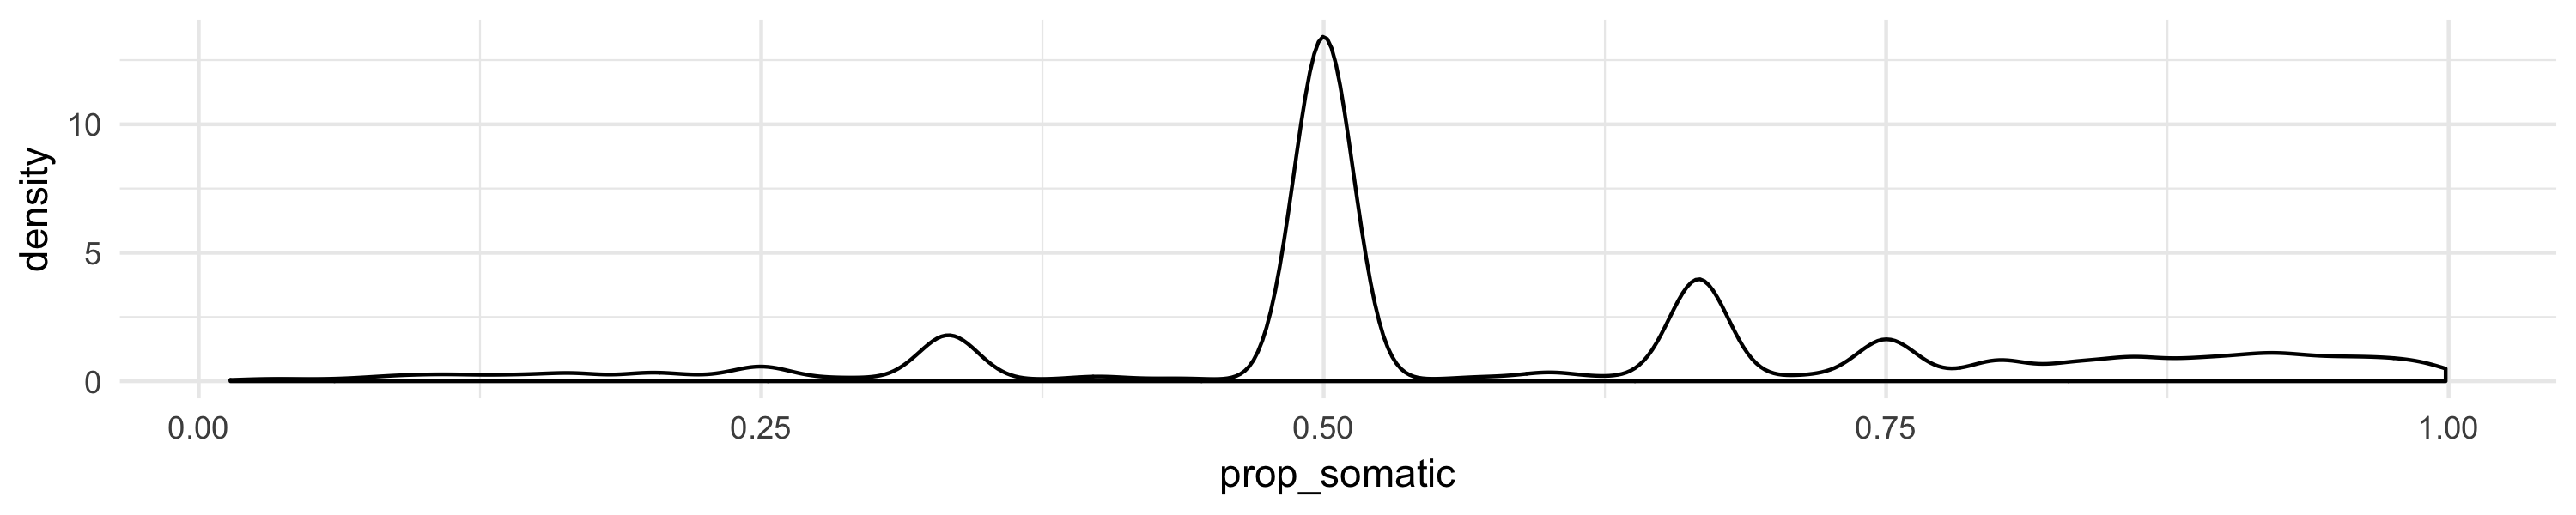

In [32]:
plot_density(keys_inconsistent_class, "prop_somatic", height = 2, adjust = 1/3)

So the errors are more uncertainity than real errors: in most cases, the mutation was equally classified as `somatic` than as `non-somatic`. However, when we study the keys that are shared by more than 5 rows, it seems that most of them are somatic mutations sometimes wrongly classified as `non-somatic`:

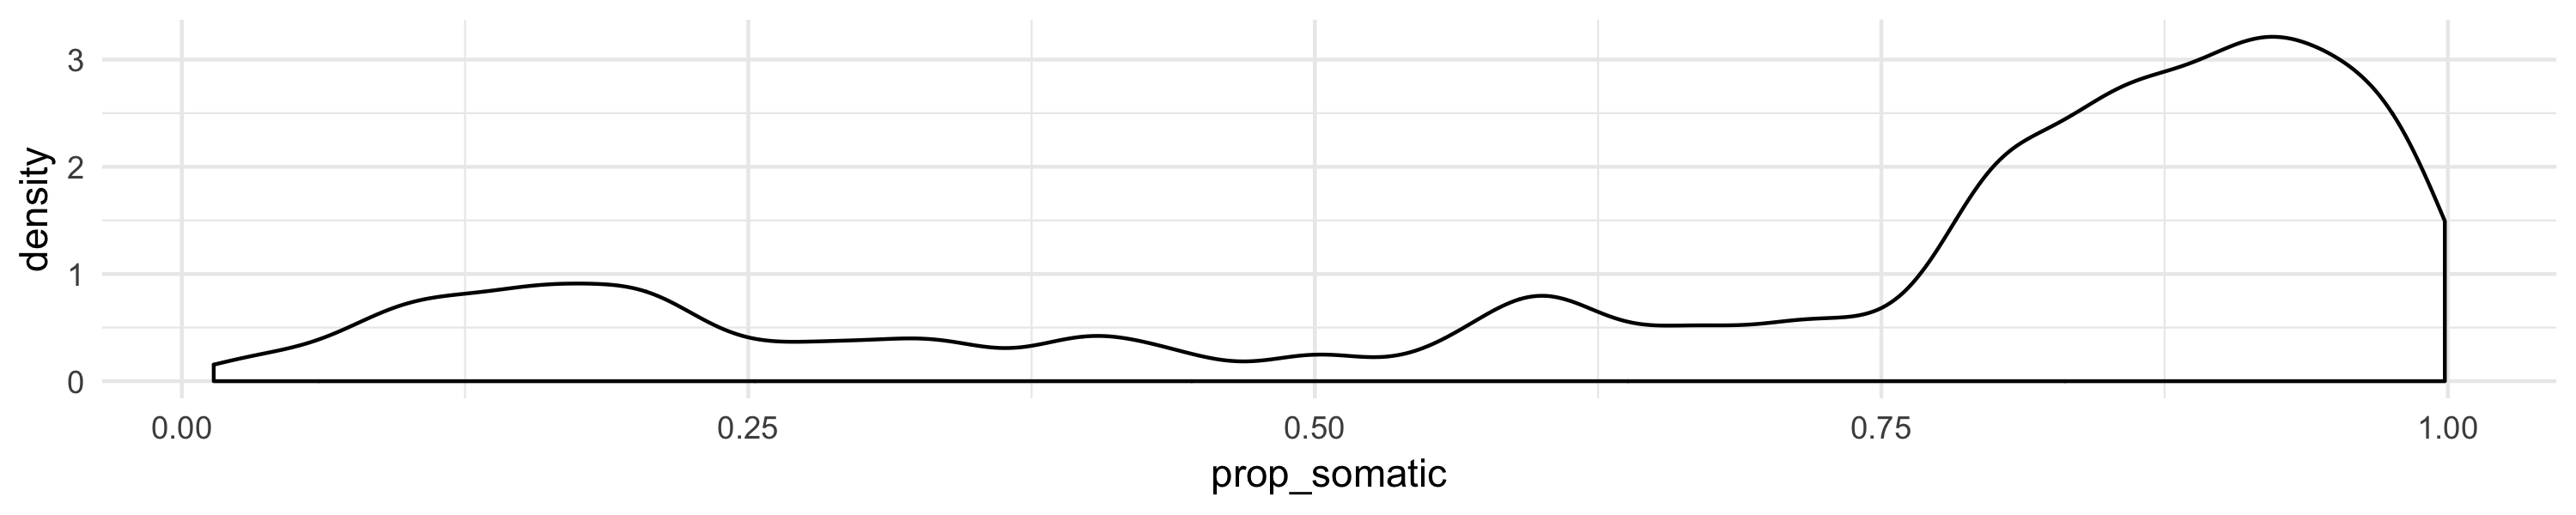

In [33]:
plot_density(keys_inconsistent_class[keys_inconsistent_class$count >= 5,], "prop_somatic", height = 2, adjust = 1/3)

So we have two types of inconsistence:
* keys were we don't know between `somatic` and `non-somatic` (~68%)
* keys that are most of the time `somatic` and sometimes classified as `non-somatic` (~32%)

In [34]:
print_count_and_proportion(nrow(keys_inconsistent_class[keys_inconsistent_class$count >= 5,]),
                           nrow(keys_inconsistent_class))

[1] "462 over 1438 (32.13%)"

In [35]:
dd <- impact[impact$mut_key %in% keys_inconsistent_class$mut_key,]
impact$category <- "all mutations"
dd$category <- "inconsistent confidence_class"
dd <- rbind(impact, dd)

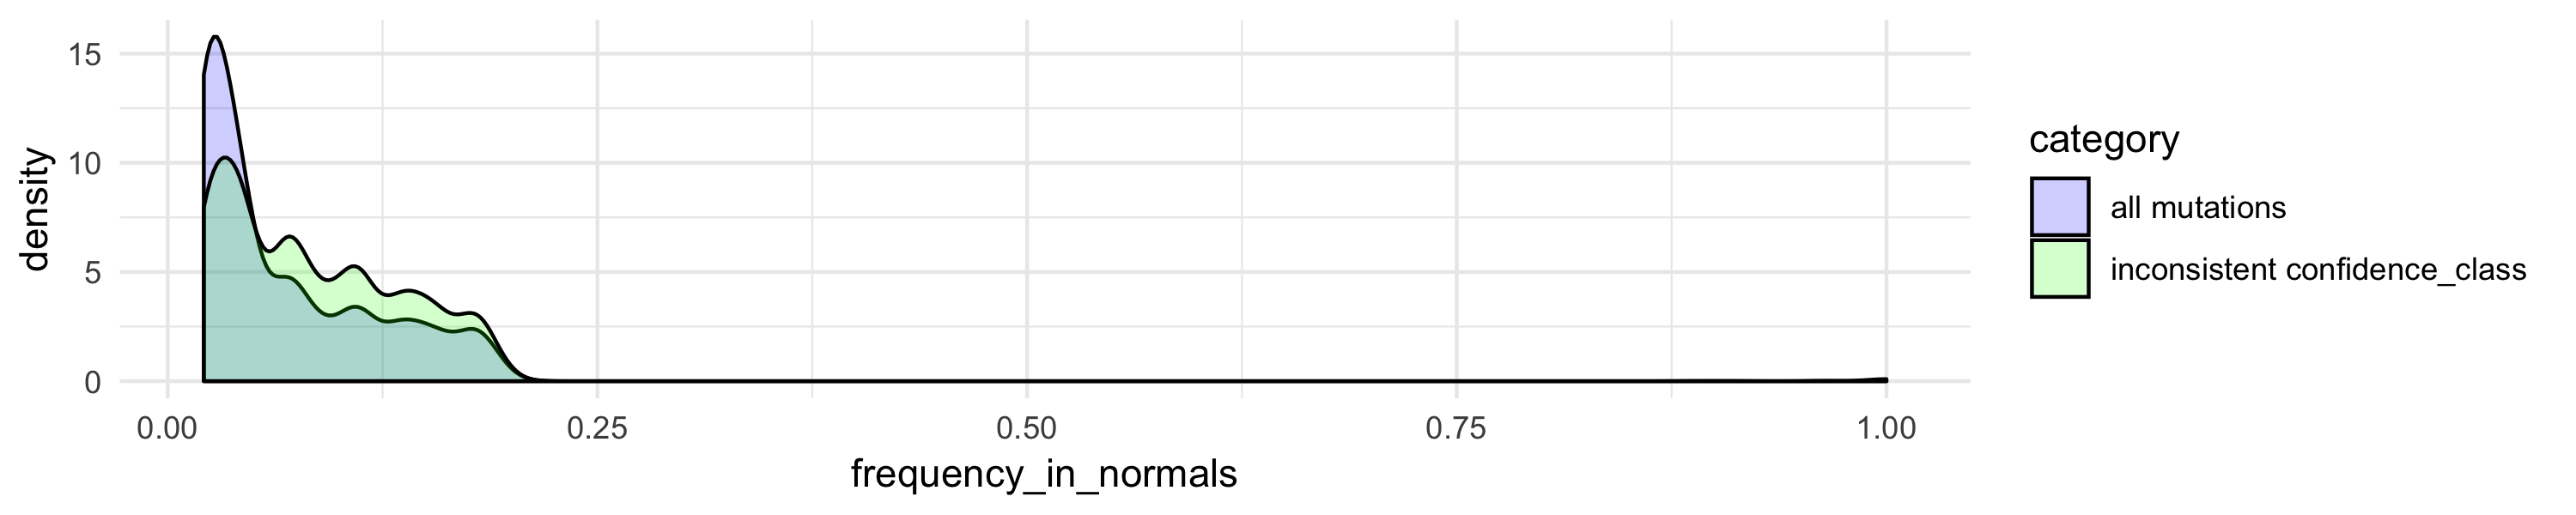

In [36]:
plot_density(dd[dd$frequency_in_normals != 0,], "frequency_in_normals", "category", height = 2)

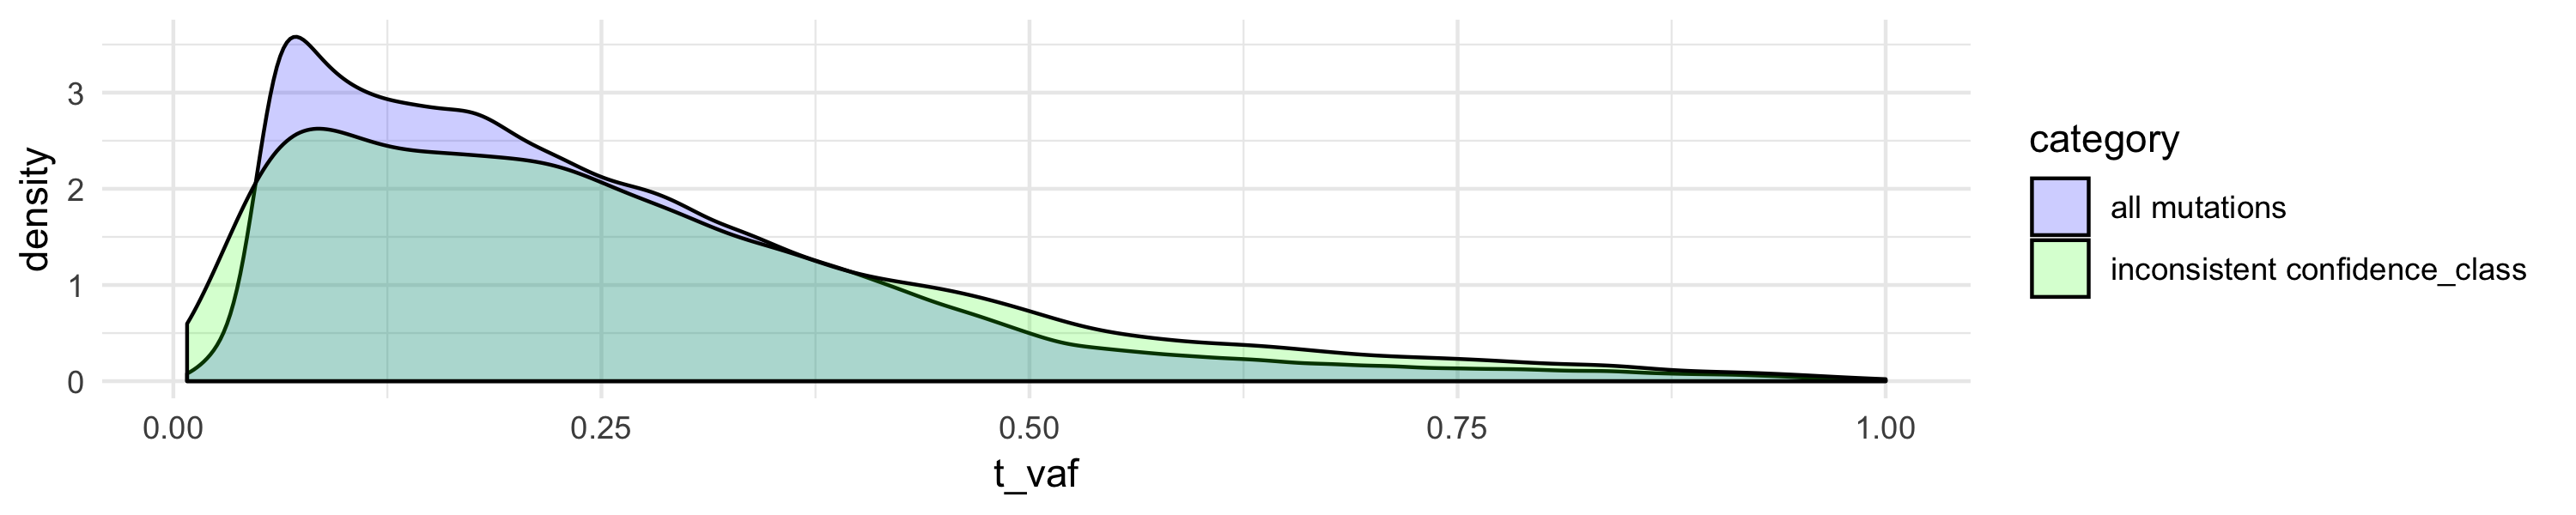

In [37]:
plot_density(dd, "t_vaf", "category", height = 2)

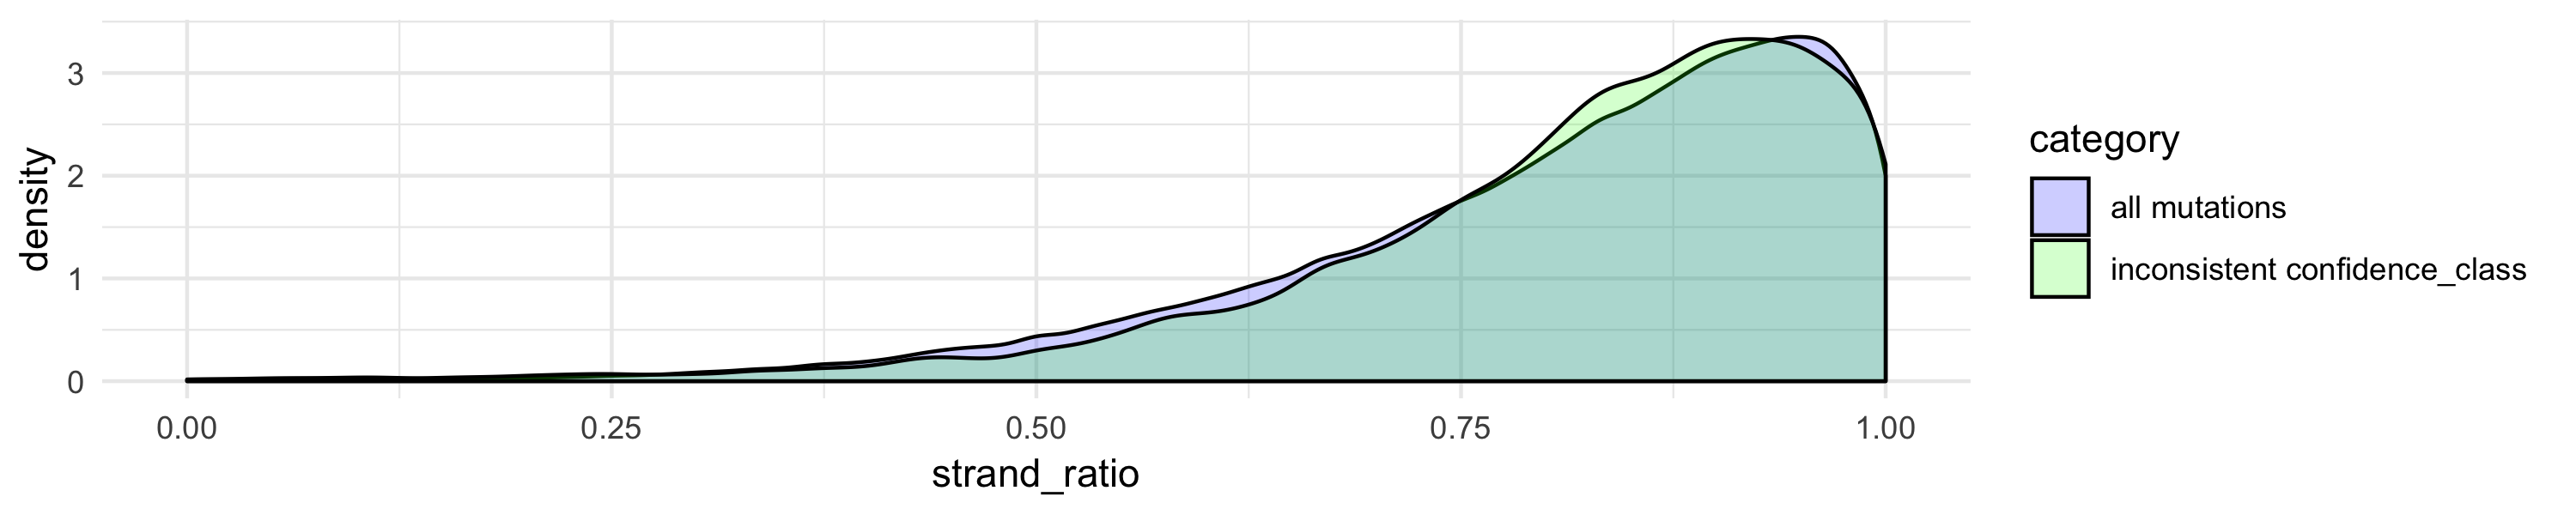

In [38]:
plot_density(dd, "strand_ratio", "category", height = 2)